In [51]:
# Importer la librairie pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [54]:
df = pd.read_csv('Data/flight_filtered.csv').sample(frac=0.1, random_state=42).drop('Unnamed: 0', axis=1)

In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df.head()

In [56]:
def map_labels(delays):
    if delays > 15:
        return 1
    else:
        return 0

df['delayed'] = ((df['DEP_DELAY'].map(map_labels) + df['ARR_DELAY'].map(map_labels)) != 0).astype(int)
df['delayed'].value_counts(normalize = True)

delayed
0    0.735635
1    0.264365
Name: proportion, dtype: float64

In [57]:
# Function to convert time to total minutes
def time_to_minutes(time_str):
    h, m, _ = map(int, time_str.split(':'))
    return h * 60 + m

In [58]:
# Convert CRS_DEP_TIME and CRS_ARR_TIME to total minutes
df['CRS_DEP_TIME_MINUTES'] = df['CRS_DEP_TIME'].apply(time_to_minutes)
df['CRS_ARR_TIME_MINUTES'] = df['CRS_ARR_TIME'].apply(time_to_minutes)

In [59]:
# Select features for the model
features = ['AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME_MINUTES', 'CRS_ARR_TIME_MINUTES', 'FL_DAY_OF_WEEK', 'FL_MONTH', 'FL_YEAR'	]
X = df[features]
y = df['delayed']

In [60]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)

In [61]:
bool_col = X_encoded.select_dtypes(include='bool').columns

In [62]:
X_encoded[bool_col] = X_encoded[bool_col].astype(int)

In [63]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [64]:
# Identify numeric columns for scaling
numeric_features = ['FL_DAY_OF_WEEK', 'FL_MONTH', 'FL_YEAR', 'CRS_DEP_TIME_MINUTES', 'CRS_ARR_TIME_MINUTES']

In [65]:
# Scale only the numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [66]:
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])


In [67]:
# Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)
y_pred_logistic = logistic_model.predict(X_test_scaled)


In [68]:
log_Train_score = logistic_model.score(X_train_scaled, y_train)
log_Test_score =logistic_model.score(X_test_scaled, y_test)

In [70]:
log_Train_score, log_Test_score

(0.7432053257042254, 0.7378149411376389)

In [71]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

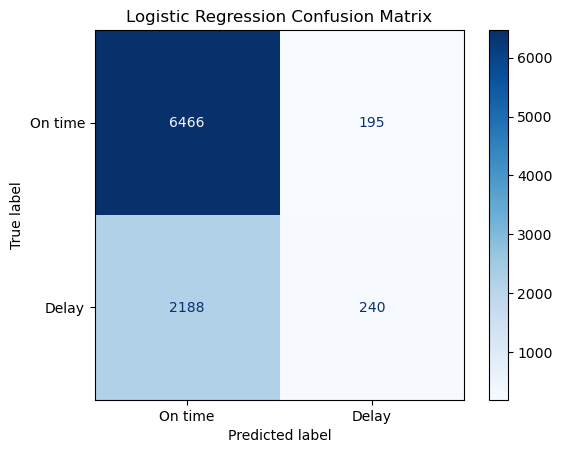

In [72]:
# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['On time', 'Delay'])
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

##API Call for Real Time Data

In [73]:
import requests
import pandas as pd
import joblib
from datetime import datetime


In [75]:
def get_real_time_data(api_key):
    url = f"http://api.aviationstack.com/v1/flights?access_key={api_key}"
    response = requests.get(url)
    return response.json()['data']

In [74]:
def preprocess_real_time_data(flight, is_test_data=False):
    features = {}
    if is_test_data:
        # For test data
        features['AIRLINE'] = flight['airline']
        features['ORIGIN'] = flight['origin']
        features['DEST'] = flight['dest']
        features['CRS_DEP_TIME_MINUTES'] = flight['dep_time']
        features['CRS_ARR_TIME_MINUTES'] = flight['arr_time']
        features['FL_DAY_OF_WEEK'] = flight['day_of_week']
        features['FL_MONTH'] = flight['month']
        features['FL_YEAR'] = flight['year']
    else:
        # For API data
        features['AIRLINE'] = flight['airline']['name']
        features['ORIGIN'] = flight['departure']['iata']
        features['DEST'] = flight['arrival']['iata']

        dep_time = datetime.fromisoformat(flight['departure']['scheduled'])
        features['CRS_DEP_TIME_MINUTES'] = dep_time.hour * 60 + dep_time.minute

        arr_time = datetime.fromisoformat(flight['arrival']['scheduled'])
        features['CRS_ARR_TIME_MINUTES'] = arr_time.hour * 60 + arr_time.minute

        flight_date = datetime.fromisoformat(flight['flight_date'])
        features['FL_DAY_OF_WEEK'] = flight_date.weekday()
        features['FL_MONTH'] = flight_date.month
        features['FL_YEAR'] = flight_date.year

    return pd.DataFrame([features])


In [76]:
def engineer_features(df):
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)

    # Convert boolean columns to int
    bool_col = df_encoded.select_dtypes(include='bool').columns
    df_encoded[bool_col] = df_encoded[bool_col].astype(int)

    # Identify numeric columns for scaling
    numeric_features = ['FL_DAY_OF_WEEK', 'FL_MONTH', 'FL_YEAR', 'CRS_DEP_TIME_MINUTES', 'CRS_ARR_TIME_MINUTES']

    # Scale numeric features
    df_encoded[numeric_features] = scaler.transform(df_encoded[numeric_features])

    return df_encoded

In [77]:
def predict_delay(flight_data, is_test_data=False):
    X = preprocess_real_time_data(flight_data, is_test_data)
    X_engineered = engineer_features(X)

    # Ensure all expected columns are present
    expected_columns = logistic_model.feature_names_in_
    missing_columns = set(expected_columns) - set(X_engineered.columns)


    missing_df = pd.DataFrame(0, index=X_engineered.index, columns=list(missing_columns))

    # Concatenate the missing columns with X_engineered
    X_engineered = pd.concat([X_engineered, missing_df], axis=1)

    # Reorder columns to match the model's expected order
    X_engineered = X_engineered.reindex(columns=expected_columns, fill_value=0)

    prediction = logistic_model.predict(X_engineered)
    probability = logistic_model.predict_proba(X_engineered)
    return prediction[0], probability[0][1]



In [78]:
test_flight = {
    'airline': 'American Airlines',  # Full airline name
    'origin': 'ATL',
    'dest': 'LAX',
    'dep_time': 780,  # 8:00 AM
    'arr_time': 920,  # 11:00 AM
    'day_of_week': 2,  # Tuesday
    'month': 7,  # July
    'year': 2023
}

In [79]:
# Make prediction
delay_prediction, delay_probability = predict_delay(test_flight, is_test_data=True)

In [80]:
print(f"Flight Details:")
print(f"Airline: {test_flight['airline']}")
print(f"From: {test_flight['origin']} to {test_flight['dest']}")
print(f"Departure Time: {test_flight['dep_time'] // 60}:{test_flight['dep_time'] % 60:02d}")
print(f"Arrival Time: {test_flight['arr_time'] // 60}:{test_flight['arr_time'] % 60:02d}")
print(f"Date: {test_flight['year']}-{test_flight['month']:02d}-{test_flight['day_of_week'] + 1}")
print(f"\nDelay Prediction: {'Delayed' if delay_prediction == 1 else 'On Time'}")
print(f"Delay Probability: {delay_probability:.2f}")

Flight Details:
Airline: American Airlines
From: ATL to LAX
Departure Time: 13:00
Arrival Time: 15:20
Date: 2023-07-3

Delay Prediction: On Time
Delay Probability: 0.20
